<a href="https://colab.research.google.com/github/Shehab37/gans/blob/main/pytorch_dcgan_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"drnykterstein0","key":"cbd1474498821dc7356831ffb711362a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c generative-dog-images
! mkdir dogs
! unzip  all-dogs.zip -d dogs

In [ ]:
import os 
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

In [ ]:
PATH = '/content/dogs/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]
                               )

train_data = datasets.ImageFolder('/content/dogs/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# class G(nn.Module):
#     def __init__(self):
#         # Used to inherit the torch.nn Module
#         super(G, self).__init__()
#         # Meta Module - consists of different layers of Modules
#         self.main = nn.Sequential(
#                 nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
#                 nn.BatchNorm2d(512),
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
#                 nn.BatchNorm2d(256),
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
#                 nn.BatchNorm2d(128),
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(True),
#                 nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
#                 nn.Tanh()
#                 )
        
#     def forward(self, input):
#         output = self.main(input)
#         return output

# # Creating the generator
# netG = G()
# netG.apply(weights_init)

In [ ]:
# # Defining the discriminator
# class D(nn.Module):
#     def __init__(self):
#         super(D, self).__init__()
#         self.main = nn.Sequential(
#                 nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
#                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                 nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
#                 nn.BatchNorm2d(128),
#                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                 nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
#                 nn.BatchNorm2d(256),
#                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                 nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
#                 nn.BatchNorm2d(512),
#                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                 nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
#                 nn.Sigmoid()
#                 )
        
#     def forward(self, input):
#         output = self.main(input)
#         # .view(-1) = Flattens the output into 1D instead of 2D
#         return output.view(-1)
    
    
# # Creating the discriminator
# netD = D()
# netD.apply(weights_init)


In [ ]:
batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

In [ ]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [ ]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow((image_array * 255).astype(np.uint8))

    plt.show()
    plt.close()

In [ ]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 1 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)

In [ ]:
show_generated_img(3)

In [ ]:
if not os.path.exists('/content/results'):
    os.mkdir('/content/results')
    
im_batch_size = 50
n_images=10000

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/results', f'image_{i_batch+i_image:05d}.png'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    # plt.imshow((j*255).astype(np.uint8))
    plt.imshow(j)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


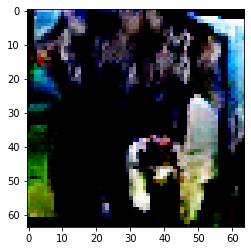

In [ ]:
np.amin(images[2])
Image = np.clip(images[2], 0, 1)
# plt.imshow(Image)
plt.imshow(images[2])
